# SLIC-ed imgs to training set

In [86]:
import matplotlib.pyplot as plt
import numpy as np
from skimage.color import rgb2gray
from skimage.filters import sobel
from skimage.segmentation import felzenszwalb, slic, quickshift, watershed
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
from matplotlib import image as mpimg
import os
from scipy.misc import imresize

In [2]:
path = '/Users/margheritarosnati/Documents/DS/2018-2/DL/DeepBlueSea/data/'
pimg = 'train_sample/'
pgt = 'train_maps/'
nfiles = len(os.listdir(path + pimg))

In [3]:

def load_image(infilename):
    """ Reads images """
    data = mpimg.imread(infilename)
    return data


def load_batch(path, pimg, pgt, nfiles, batch_size=1000):
    # sample randomly
    randomise = np.random.choice(nfiles, size=batch_size, replace=False)

    # generate file lists
    # code design choice: generating a priori filelist was quite slow, hence doing it here
    print('Reading file names ..')
    filelist = []
    for i in randomise:
        filelist = filelist + [os.listdir(path + pimg)[i]]
    gtlist = ['gt_' + filelist[i] for i in range(batch_size)]
    print('read')
    # initialise datasets
    imgs = []
    gts = []

    # read files
    print('Reading ', batch_size, ' files...')
    for i in range(batch_size):
        name = path + pimg + filelist[i]
        if name[-4:] == ".jpg":
            imgs.append(load_image(name))
        gtname = path + pgt + gtlist[i]
        if gtname[-4:] == ".jpg":
            gts.append(load_image(gtname))
    # print(len(imgs)) #debug
    imgs = np.asarray(imgs)
    gts = np.asarray(gts)
    print('read')
    print('Check: img size', imgs.shape, '\tgt size', gts.shape)
    return [imgs, gts]
    # TODO: return these for next step in pipeline


In [117]:
batch_size = 10
# get some data
[imgs, gts] = load_batch(path, pimg, pgt, nfiles, batch_size)

Reading file names ..
read
Reading  10  files...
read
Check: img size (10, 768, 768, 3) 	gt size (10, 768, 768)


In [118]:
# safekeeping - sometimes you do dumb things
imsave = np.copy(imgs)
gtsave = np.copy(gts)

In [119]:
# create SLIC megapixels
# I am lame and will do a loop
n_segments = 100
SLIC = np.asarray([slic(imgs[i,:], n_segments, compactness=20, sigma=10) for i in range(imgs.shape[0])])

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:155: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_z = grid_z[slices]
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:156: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  segments_y = grid_y[slices]
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/skimage/segmentation/slic_superpixels.py:157: FutureWarning: Using a non-tuple sequence for multidimensional indexi

In [120]:
#
# DEBUG
#
# check this worked out:
SLIC.shape

(10, 768, 768)

In [7]:
# find smallest patch around each pixel - function
def box(seg, i):
    xind = np.nonzero(seg.ravel('C') == i)
    [xmax, temp] = np.unravel_index(np.max(xind), seg.shape, order = 'C')
    [xmin, temp] = np.unravel_index(np.min(xind), seg.shape, order = 'C')
    yind = np.nonzero(seg.ravel('F') == i)
    [temp, ymax] = np.unravel_index(np.max(yind), seg.shape, order = 'F')
    [temp, ymin] = np.unravel_index(np.min(yind), seg.shape, order = 'F')
    return np.array([xmax, ymax, xmin, ymin])

In [121]:
#
# DEBUG
#
# test
i=98
j=0
try:
    box(SLIC[j,:],i)
except ValueError:
    np.array([0,0,0,0])
np.max(SLIC, axis=(1,2))

array([99, 99, 99, 99, 99, 99, 99, 99, 99, 98])

In [13]:
# initialise boxes
boxes = np.zeros((batch_size, n_segments, 4))

In [122]:
# run box function to find all superpixel patches sizes
for i in range(batch_size):
    for j in range(n_segments):
        # sometimes we get less than n_segment boxes
        try:
            boxes[i,j,:] = box(SLIC[i,:],j)
        except ValueError:
            boxes[i,j,:] = np.array([0,0,0,0])
        #print(i,j)

In [123]:
#
# DEBUG
#
# check this worked out:
boxes.shape

(10, 100, 4)

In [124]:
# create training set for gts
thres = 0.25
def patch_cat(gt, SLIC, i, thres):
    num = np.sum(gt[SLIC == i] > 125)
    denom = gt[SLIC == i].size
    if float(num)/float(denom)>thres:
        return 1
    else:
        return 0

In [125]:
# initialise y_train - setting y to -1 for noon-existing patches
y_train = np.zeros((10, 100))-1

In [126]:
# populate y_train using patch_cat
thres = 0.001
for j in range(batch_size):
    for i in range(np.max(SLIC[j,:])):
        y_train[j,i] = patch_cat(gts[j,:], SLIC[j,:], i, thres)

In [127]:
#
# DEBUG
#
# checking
print(y_train.shape, np.nonzero(y_train[5,:]>0))

(10, 100) (array([], dtype=int64),)


In [131]:
# creating training set for x
final_size = 80
def xpatchify(img, SLIC, boxed, i):
    [inda, indb] = np.nonzero(SLIC!=i)
    imtemp = np.copy(img)
    imtemp[inda,indb,:] = 0
    x_temp = imtemp[int(boxed[2]):int(boxed[0]), 
                 int(boxed[3]):int(boxed[1])]
    x_train = imresize(x_temp, (80,80))
    #plt.imshow(x_train)
    #plt.show()
    return(x_train)

In [129]:
# initialising x_train
x_train = np.zeros((batch_size,
                   n_segments,
                   final_size,final_size,3))

In [132]:
# populating x_train
for i in range(batch_size):
    for j in range(np.max(SLIC[i,:])):
        x_train[i,j,:] = xpatchify(imgs[i,:], SLIC[i,:], boxes[i,j,:], j)

/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:482: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Users/margheritarosnati/anaconda3/lib/python3.6/site-packages/scipy/misc/pilutil.py:485: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [144]:
### FINAL RESULTS
#y_train
#x_train
print(y_train.shape,x_train.shape)

(10, 100) (10, 100, 80, 80, 3)


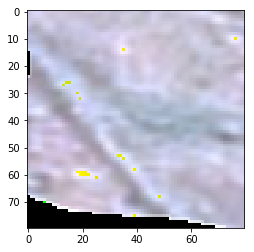

In [143]:
#
# DEBUG
#
# checking
plt.imshow(x_train[9,10,:])
#plt.imshow(xpatchify(imgs[9,:], SLIC[9,:], boxes[9,78,:], 78))#x_train[5,78,:])
plt.show()

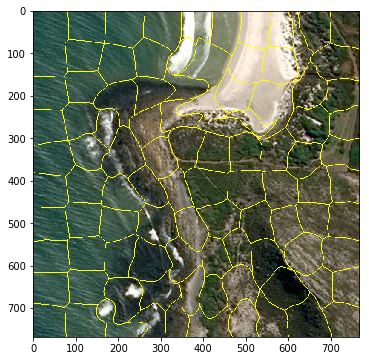

In [139]:
#
# DEBUG
#
# checking
i = 9
plt.figure(figsize=(6,6))
plt.imshow(mark_boundaries(imgs[i,:], SLIC[i,:]))
plt.show()

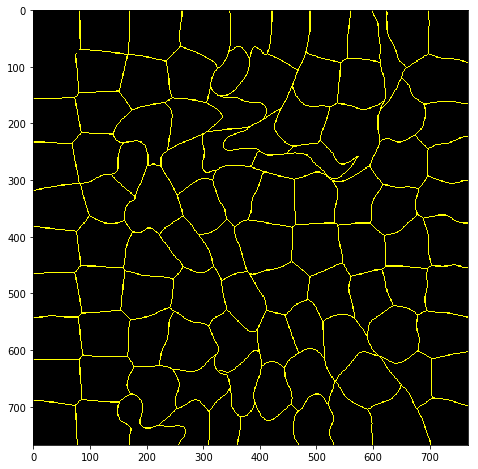

In [141]:
#
# DEBUG
#
# checking
plt.figure(figsize=(8,8))
plt.imshow(mark_boundaries(gts[i,:], SLIC[i,:]))
plt.show()